In [3]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
import pandas as pd

import numpy as np
import os
import shutil
import posixpath
import wfdb
import seaborn as sn

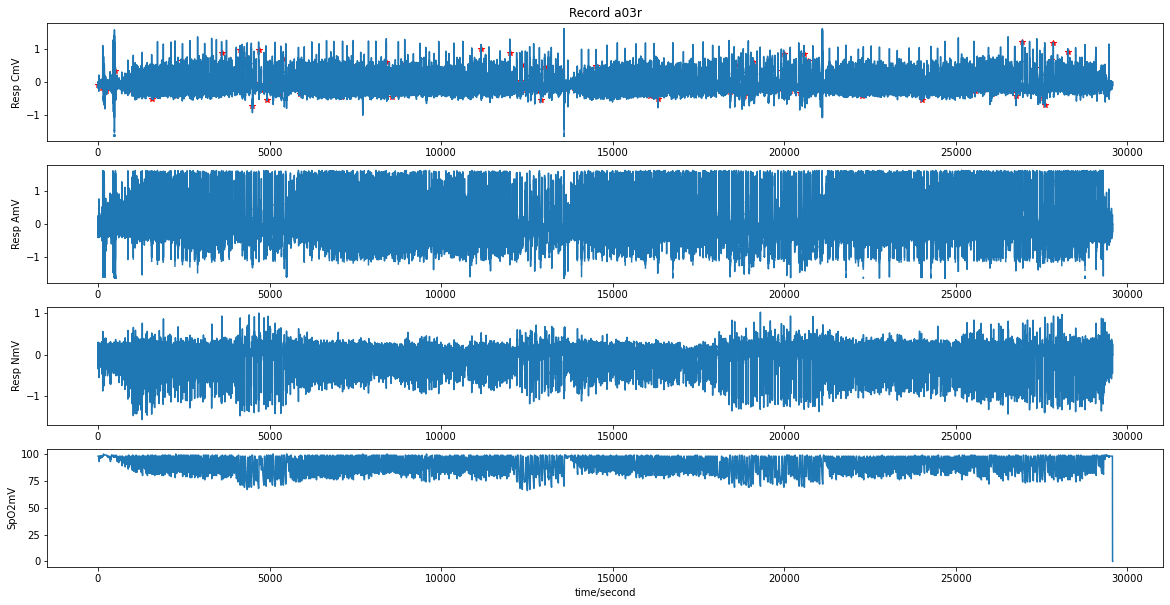

{'record_name': 'a01r',
 'n_sig': 4,
 'fs': 100,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 2956796,
 'base_time': None,
 'base_date': None,
 'comments': [],
 'sig_name': ['Resp C', 'Resp A', 'Resp N', 'SpO2'],
 'p_signal': array([[-0.1015 , -0.3446 ,  0.23545, 98.     ],
        [-0.1025 , -0.3455 ,  0.2364 , 98.     ],
        [-0.1035 , -0.3464 ,  0.23735, 98.     ],
        ...,
        [ 0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.     ,  0.     ,  0.     ]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['a01r.dat', 'a01r.dat', 'a01r.dat', 'a01r.dat'],
 'fmt': ['16', '16', '16', '16'],
 'samps_per_frame': [1, 1, 1, 1],
 'skew': [None, None, None, None],
 'byte_offset': [None, None, None, None],
 'adc_gain': [20000.0, 20000.0, 20000.0, 1.0],
 'baseline': [0, 0, 0, 0],
 'units': ['mV', 'mV', 'mV', 'mV'],
 'adc_res': [16, 16, 16, 16],
 'adc_zero': [0, 0, 0, 0],
 'init_val

In [246]:
# docs: https://wfdb.readthedocs.io/en/latest/wfdb.html
# SpO2が含まれているデータは a01r のようにrが付いている
# records

subjects = ['a01r', 'a02r', 'a03r', 'a04r', 'b01r', 'c01r', 'c02r', 'c03r']
records = {}

# データの読み込み
for subject in subjects:
    records[subject] = wfdb.rdrecord(subject)  # 計測データ
    records['ann_' + subject] = wfdb.rdann(subject, 'apn', shift_samps=True) # ラベル

#record = wfdb.rdrecord('a01r')
#annotation = wfdb.rdann('a01r', 'apn', shift_samps=True)

wfdb.plot_wfdb(record=records['a01r'], annotation=records['ann_a01r'], title='Record a03r', time_units='seconds', figsize=(20,10)) 
display(records['a01r'].__dict__)

In [247]:
# https://archive.physionet.org/physiobank/database/apnea-ecg/annotations.shtml
# display(annotation.__dict__)
display(len(records['ann_a01r'].sample))
display(len(records['ann_a01r'].symbol))

3108000 / 6000

489

489

518.0

In [249]:
print(record.p_signal.size)  # 4つの信号×時間 = サイズ

# 4信号で割ってアノテーションの個数で割ると大体6000sampleになる
# https://www.physionet.org/lightwave/?db=apnea-ecg/1.0.0 でテストデータを確認できる
# a03rの場合、08:37:50以降はアノテーションの記録がない

print(records['a01r'].p_signal.size / 4 / 489)

2790000
6046.617586912065


In [307]:
# 特徴量の抽出、学習用のデータ作成
# 1 sample(6000個のデータ)毎に基本統計量を出してそれをInputに与える
# 例) record.p_signal[0:6000], record.p_signal[6001:12001]で統計量を出す

# train用
train_subjects = ['a01r', 'a02r', 'a03r', 'a04r', 'b01r', 'c01r', 'c02r']

# test用
test_subjects = ['c03r']

data_array = []
for subject in train_subjects:
    # annotation分だけ繰り返す
    ann_count = len(records['ann_'+subject].sample)
    data = pd.DataFrame(records[subject].p_signal, columns=records[subject].sig_name, dtype='float')
    print(data.head())

    # 基本統計量を出す
    # data.describe()
    # ピークの差 (data.max() - data.min()).values
    # np.hstack([data.mean().values, data.std().values, data.max().values, data.min().values])
    start_idx = 0
    end_idx = 6000
    for n in range(0, ann_count):
        data_array.append(extract_feature(data[start_idx:end_idx]))
        start_idx = end_idx + 1
        end_idx = end_idx + 6000

test_data = []
for subject in test_subjects:
    ann_count = len(records['ann_'+subject].sample)
    data = pd.DataFrame(records[subject].p_signal, columns=records[subject].sig_name, dtype='float')
    print(data.head())
    start_idx = 0
    end_idx = 6000
    for n in range(0, ann_count):
        test_data.append(extract_feature(data[start_idx:end_idx]))
        start_idx = end_idx + 1
        end_idx = end_idx + 6000
        
def extract_feature(data):
    return np.hstack([data.mean().values, data.std().values, data.max().values, data.min().values])

   Resp C  Resp A   Resp N  SpO2
0 -0.1015 -0.3446  0.23545  98.0
1 -0.1025 -0.3455  0.23640  98.0
2 -0.1035 -0.3464  0.23735  98.0
3 -0.1045 -0.3473  0.23830  98.0
4 -0.1055 -0.3482  0.23925  98.0
    Resp C   Resp A   Resp N  SpO2
0 -0.08525  0.22005 -0.41895  96.0
1 -0.08435  0.20915 -0.40935  96.0
2 -0.08345  0.19830 -0.39980  96.0
3 -0.08260  0.18740 -0.39030  96.0
4 -0.08170  0.17655 -0.38070  96.0
    Resp C   Resp A   Resp N  SpO2
0 -0.06790 -0.06185 -0.50170  92.0
1 -0.06695 -0.06105 -0.50270  92.0
2 -0.06605 -0.06030 -0.50375  92.0
3 -0.06510 -0.05955 -0.50475  92.0
4 -0.06420 -0.05880 -0.50580  92.0
    Resp C   Resp A   Resp N  SpO2
0 -0.14035 -0.14400  0.10895  93.0
1 -0.14060 -0.14650  0.11435  93.0
2 -0.14090 -0.14900  0.11980  93.0
3 -0.14120 -0.15155  0.12525  93.0
4 -0.14150 -0.15405  0.13070  93.0
    Resp C   Resp A   Resp N  SpO2
0 -0.09515 -0.08015 -0.04765   0.0
1 -0.09480 -0.07995 -0.04770   0.0
2 -0.09445 -0.07975 -0.04775   0.0
3 -0.09410 -0.07960 -0.04780   0

In [308]:
# 学習データ作成
print(len(data_array))
train_X = np.array(data_array)

print(train_X[0].size)
print(train_X[1])
type(train_X)

train_X.shape

# テストデータ作成
print(len(test_data))
test_X = np.array(test_data)
test_X.shape

3501
16
[-5.64733956e-02 -4.05511169e-02  2.24443074e-02  9.73498916e+01
  5.26096529e-02  1.58064974e-01  1.38697215e-01  6.78662729e-01
  8.91000000e-02  5.25450000e-01  3.17350000e-01  9.80000000e+01
 -1.90200000e-01 -4.06650000e-01 -2.87250000e-01  9.60000000e+01]
454


(454, 16)

In [309]:
# NとAを1,0に変換する
from sklearn.preprocessing import LabelEncoder

label_data = []
for subject in train_subjects:
    le = LabelEncoder()
    le = le.fit(annotation.symbol)
    labels = le.transform(records['ann_' + subject].symbol)
    label_data = np.concatenate([label_data, labels], 0)

# テスト用のラベル
test_label = []
for subject in test_subjects:
    le = LabelEncoder()
    le = le.fit(annotation.symbol)
    test_label = le.transform(records['ann_' + subject].symbol)

In [310]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split
from keras.utils import np_utils


# モデルの作成
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(16, 1)),
    keras.layers.Dense(100, activation='sigmoid'),
    keras.layers.Dense(100, activation='sigmoid'),
    keras.layers.Dense(1, activation='softmax')
])

In [311]:
from keras import optimizers
from keras.utils import plot_model

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_32 (Flatten)         (None, 16)                0         
_________________________________________________________________
dense_80 (Dense)             (None, 100)               1700      
_________________________________________________________________
dense_81 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_82 (Dense)             (None, 1)                 101       
Total params: 11,901
Trainable params: 11,901
Non-trainable params: 0
_________________________________________________________________


In [312]:
history = model.fit(train_X, label_data,
                    batch_size=128,
                    epochs=50)

Epoch 1/50
28/28 [==============================] - 0s 1ms/step - loss: 0.6862 - accuracy: 0.5346
Epoch 2/50
28/28 [==============================] - 0s 1ms/step - loss: 0.4752 - accuracy: 0.5425
Epoch 3/50
28/28 [==============================] - 0s 1ms/step - loss: 0.3114 - accuracy: 0.5463
Epoch 4/50
28/28 [==============================] - 0s 1ms/step - loss: 0.2212 - accuracy: 0.5343
Epoch 5/50
28/28 [==============================] - 0s 1ms/step - loss: 0.1674 - accuracy: 0.5296
Epoch 6/50
28/28 [==============================] - 0s 1ms/step - loss: 0.1547 - accuracy: 0.5460
Epoch 7/50
28/28 [==============================] - 0s 1ms/step - loss: 0.1506 - accuracy: 0.5392
Epoch 8/50
28/28 [==============================] - 0s 1ms/step - loss: 0.1517 - accuracy: 0.5311
Epoch 9/50
28/28 [==============================] - 0s 1ms/step - loss: 0.1279 - accuracy: 0.5521
Epoch 10/50
28/28 [==============================] - 0s 1ms/step - loss: 0.1199 - accuracy: 0.5338
Epoch 11/50
28/28 [

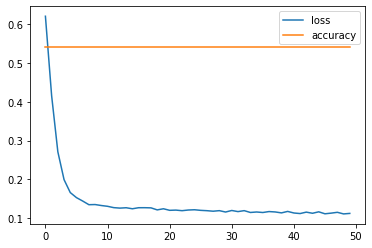

In [306]:
# plotしてみる
pd.DataFrame(history.history)[['loss', 'accuracy']].plot()

In [329]:
print("Evaluate on test data")
results = model.evaluate(test_X, test_label, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(test_X[:3])
print("predictions shape:", predictions.shape)

Evaluate on test data
4/4 [==============================] - 0s 2ms/step - loss: 0.0273 - accuracy: 1.0000
test loss, test acc: [0.027328094467520714, 1.0]
Generate predictions for 3 samples
predictions shape: (3, 1)


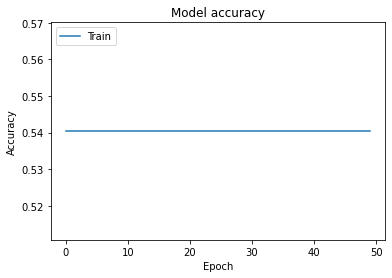

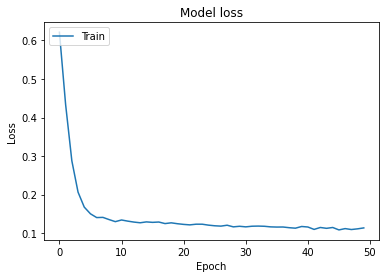

In [326]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()